In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-optimize


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

from skopt import BayesSearchCV
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
train_path  = '/content/drive/MyDrive/Colab Notebooks/cs-506-extra-credit/train.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/cs-506-extra-credit/test.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

### training data EDA

In [ ]:
train_data.head()

,id,trans_num,trans_date,trans_time,unix_time,category,amt,cc_num,first,last,...,zip,lat,long,city_pop,job,dob,merchant,merch_lat,merch_long,is_fraud
0,308467,26ad750c2ff71f32631b58913582d70a,2024-01-10,06:49:39,1704887379,misc_pos,188.38,676355457570,Andrea,Johnson,...,62220,38.5127,-89.9847,95666,Accounting technician,1983-05-26,fraud_Turcotte-Halvorson,39.268874,-89.273447,0
1,261578,fea9c1efe3f2b97f27ad0ab5409ec861,2024-01-06,02:37:50,1704526670,grocery_pos,102.63,377178373574671,Rhonda,Chavez,...,21784,39.4567,-76.9696,37941,"Designer, graphic",1976-12-03,fraud_Schamberger-O'Keefe,39.961495,-76.707640,0
2,341,2ae350b982be840f3666273e0c2f3a05,2024-01-18,21:40:21,1705632021,entertainment,1.62,3599292013370451,Stephen,Khan,...,49735,45.0125,-84.6723,19515,Careers information officer,1999-08-24,"fraud_Nicolas, Hills and McGlynn",44.393561,-85.342323,0
3,1147639,bbdd8adfc0a34ed0e817f809193c85c0,2024-01-21,16:20:15,1705872015,health_fitness,5.64,3594292572430345,Justin,Reilly,...,44256,41.1404,-81.8584,62039,"Merchandiser, retail",1930-02-24,fraud_Cormier LLC,40.283764,-81.639361,0
4,314152,fc7756004dc2a9bc450eb894a670b804,2024-01-21,19:36:26,1705883786,health_fitness,97.09,4867547663675548,Alice,Duarte,...,91501,34.1862,-118.3009,106841,Prison officer,1951-10-15,fraud_Kulas Group,35.149704,-118.087440,0


In [ ]:
len(train_data)

370703

In [ ]:
train_data.dtypes

,0
id,int64
trans_num,object
trans_date,object
trans_time,object
unix_time,int64
category,object
amt,float64
cc_num,int64
first,object
last,object


In [ ]:
train_data['is_fraud'] = train_data['is_fraud'].astype(int)

In [ ]:
train_data.isna().sum()

,0
id,0
trans_num,0
trans_date,0
trans_time,0
unix_time,0
category,0
amt,0
cc_num,0
first,0
last,0


In [ ]:
train_data.describe()

,id,unix_time,amt,cc_num,zip,lat,long,city_pop,merch_lat,merch_long
count,3.707030e+05,3.707030e+05,370703.000000,3.707030e+05,370703.000000,370703.000000,370703.000000,3.707030e+05,370703.000000,370703.000000
mean,4.080297e+05,1.705433e+09,123.499358,3.862304e+17,51525.494701,37.528550,-92.158261,2.991079e+05,37.527942,-92.158460
std,3.361065e+05,7.615549e+05,244.813193,1.260746e+18,29974.830535,5.282128,16.623988,5.644602e+05,5.313384,16.632693
min,0.000000e+00,1.704085e+09,1.000000,6.040027e+10,1001.000000,19.207900,-162.305600,1.040000e+02,18.210010,-163.171646
25%,1.325125e+05,1.704729e+09,12.360000,1.800195e+14,27705.000000,33.851200,-99.103700,1.924000e+04,33.763643,-99.329107
50%,3.162290e+05,1.705435e+09,52.210000,3.513445e+15,48214.000000,38.471800,-87.453200,6.381200e+04,38.371536,-87.197353
75%,6.121395e+05,1.706073e+09,106.260000,4.643524e+15,78501.000000,41.230800,-80.063800,2.428030e+05,41.298640,-79.776034
max,1.344214e+06,1.706764e+09,17620.830000,4.999601e+18,99921.000000,64.854400,-67.040800,2.906700e+06,65.819961,-66.249287


In [ ]:
# we found 1 categorical feature has 14 distinct values
len(train_data['category'].value_counts())

14

In [ ]:
# Calculate fraud rate for each category
category_fraud_rates = train_data.groupby('category')['is_fraud'].mean().sort_values()

# Print the results
category_fraud_rates

,is_fraud
category,
grocery_net,0.036703
home,0.044617
kids_pets,0.048493
health_fitness,0.049457
food_dining,0.051661
personal_care,0.058390
travel,0.060936
entertainment,0.064164
misc_pos,0.073338


In [ ]:
# we fliter these 3 categories, with the top 3 fraud rates, for a specific model.
selected_category = ['grocery_pos', 'shopping_net', 'misc_net']

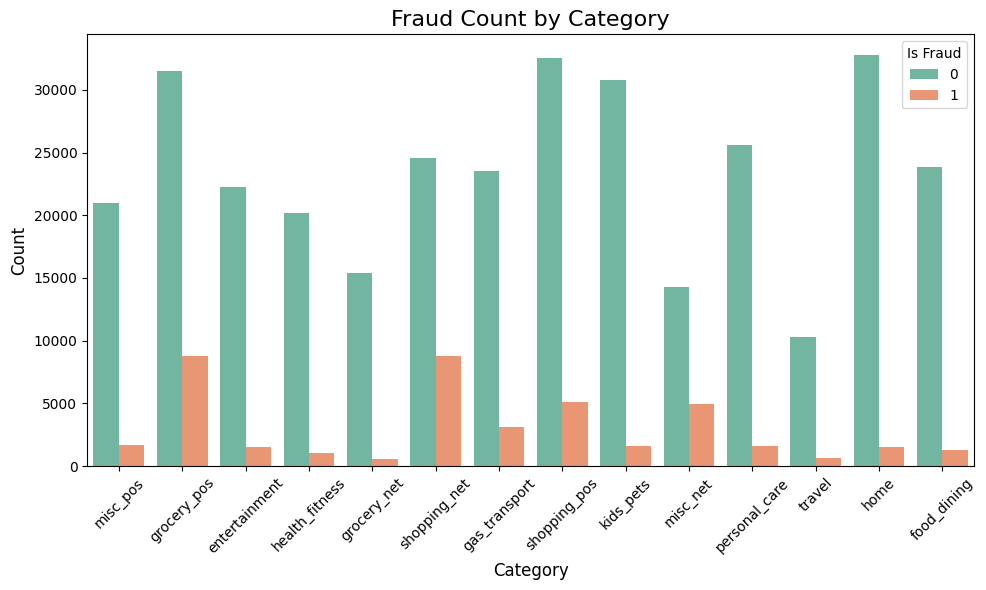

In [ ]:
# Plot the countplot
plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='category', hue='is_fraud', palette='Set2')
plt.title('Fraud Count by Category', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Is Fraud', loc='upper right')
plt.tight_layout()
plt.show()

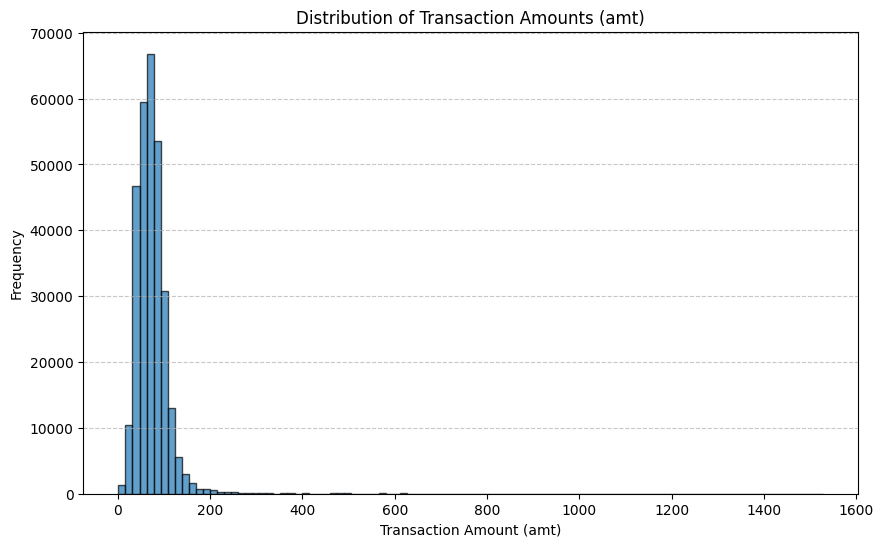

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of the 'amt' column
plt.figure(figsize=(10, 6))
plt.hist(X_train['historical_mean_amt'], bins=100, edgecolor='k', alpha=0.7)
plt.title('Distribution of Transaction Amounts (amt)')
plt.xlabel('Transaction Amount (amt)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### feature engineering

In [ ]:
train_data.iloc[0]

,0
id,308467
trans_num,26ad750c2ff71f32631b58913582d70a
trans_date,2024-01-10
trans_time,06:49:39
unix_time,1704887379
category,misc_pos
amt,188.38
cc_num,676355457570
first,Andrea
last,Johnson


In [ ]:
# helpers

# Helper function to calculate distance between two coordinates (Haversine formula)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return round(R * c, 3)

In [ ]:
def featrue_engineering(df, dropped_features, label_features, is_training=True, training_dicts=None):
  df_result = df.copy()
  if is_training and 'is_fraud' in df_result.columns:
    df_result['is_fraud'] = df_result['is_fraud'].astype(int)

  # time features
  df_result['trans_date'] = pd.to_datetime(df_result['trans_date'])
  df_result['trans_time'] = pd.to_datetime(df_result['trans_time'], format='%H:%M:%S')

  # df_result['trans_year'] = df_result['trans_date'].dt.year
  # df_result['trans_month'] = df_result['trans_date'].dt.month
  df_result['trans_day'] = df_result['trans_date'].dt.day
  df_result['trans_dayofweek'] = df_result['trans_date'].dt.dayofweek
  df_result['hour_of_day'] = df_result['trans_time'].dt.hour

  # not using unix time features, because they are about the same prediction power as trans_time & trans_date

  df_result = pd.get_dummies(df_result, columns=['category', 'state', 'gender'], drop_first=True)

  # distance between the merchant and the person
  df_result['distance'] = haversine(df_result['lat'], df_result['long'], df_result['merch_lat'], df_result['merch_long'])

  df_result['dob'] = pd.to_datetime(df_result['dob'])
  df_result['age'] = (df_result['trans_date'] - df_result['dob']).dt.days // 365


  # cc_num features
  if is_training:
    cc_num_transaction_count = df_result.groupby('cc_num').size().reset_index(name='total_transactions')
  else:
    cc_num_transaction_count = training_dicts['cc_num_transaction_count']


  df_result = df_result.merge(cc_num_transaction_count, on='cc_num', how='left')
  df_result['total_transactions'].fillna(0, inplace=True)

  if is_training:
    global_mean_amt = df_result[df_result['is_fraud'] == 0]['amt'].mean()
    historical_mean_amt = df_result[df_result['is_fraud'] == 0].groupby('cc_num')['amt'].mean().reset_index(name='historical_mean_amt')
  else:
    global_mean_amt = training_dicts['global_mean_amt']
    historical_mean_amt = training_dicts['historical_mean_amt']


  # df_result = df_result.merge(historical_mean_amt, on='cc_num', how='left') # Merge the feature back into the original dataset
  # df_result['historical_mean_amt'].fillna(global_mean_amt, inplace=True)


  # job feature -- target encoding
  if is_training:
    job_fraud_rate = df_result.groupby('job')['is_fraud'].mean().reset_index(name='job_fraud_rate')
    global_fraud_rate = df_result['is_fraud'].mean()
  else:
    job_fraud_rate = training_dicts['job_fraud_rate']
    global_fraud_rate = training_dicts['global_fraud_rate']


  # # Merge the encoded feature back into the dataset
  df_result = df_result.merge(job_fraud_rate, on='job', how='left')
  df_result['job_fraud_rate'].fillna(global_fraud_rate, inplace=True)



  # mechant
  global_avg_amt = df_result['amt'].mean()

  # Correct the merging step by keeping the 'merchant' column during drop
  if is_training:
    merchant_stats = df_result.groupby('merchant').agg(
        merchant_avg_amt=('amt', 'mean'),
        merchant_trans_count=('merchant', 'count'),
        merchant_fraud_count=('is_fraud', 'sum')
    ).reset_index()
  else:
    merchant_stats = training_dicts['merchant_stats']

  # Calculate fraud percentage
  # merchant_stats['merchant_fraud_pct'] = merchant_stats['merchant_fraud_count'] / merchant_stats['merchant_trans_count']
  # Merge back into the dataset
  df_result = df_result.merge(merchant_stats, on='merchant', how='left')
  df_result['merchant_avg_amt'].fillna(global_avg_amt, inplace=True)
  df_result['merchant_trans_count'].fillna(0, inplace=True)
  df_result['merchant_fraud_count'].fillna(0, inplace=True)
  # df_result['merchant_fraud_pct'].fillna(global_fraud_rate, inplace=True)


  # final handling
  if is_training:
    y = df_result[label_features]

    df_result.drop(columns=dropped_features+label_features, inplace=True)

    training_dicts_tts = {
    'cc_num_transaction_count': cc_num_transaction_count,
    'global_mean_amt': global_mean_amt,
    'historical_mean_amt': historical_mean_amt,
    'job_fraud_rate': job_fraud_rate,
    'global_fraud_rate': global_fraud_rate,
    'merchant_stats': merchant_stats
    }

    return df_result, y, training_dicts_tts
  else:
    df_result.drop(columns=dropped_features, inplace=True)

    return df_result, None, None


In [ ]:
dropped_features = ['id', 'trans_num', 'trans_date', 'trans_time', 'first', 'last', 'street', 'city', 'job', 'dob', 'merchant',
                    'cc_num',
                    'unix_time',
                    'merch_lat', 'merch_long', 'zip',
                    'merchant_avg_amt',
                    'merchant_fraud_count',
                  ]
label_features = ['is_fraud']

We want to first train-test-split the dataset, and then do the feature engineering

In [42]:
# we ignore the time series order in train-test-split, because the test data ignore the time sequence as well.
train_data_y = train_data['is_fraud']
X_train_r, X_test_r, y_train, y_test = train_test_split(train_data, train_data_y, test_size=0.2, random_state=42, stratify=train_data_y)

In [43]:
X_train, _, training_dicts_curr1 = featrue_engineering(X_train_r, dropped_features, label_features)

X_test1, _, _  = featrue_engineering(X_test_r, dropped_features, label_features, is_training=False, training_dicts=training_dicts_curr1)
X_test1.drop(columns=['is_fraud'], inplace=True)

In [ ]:
# check correlation
# Calculate correlation matrix
correlation_matrix = X_train.corr(numeric_only=True) # df_train_X.corr(numeric_only=True)

# Set a correlation threshold
threshold = 0.5

# Filter the correlation matrix
filtered_corr = correlation_matrix[(np.abs(correlation_matrix) >= threshold) & (correlation_matrix != 1.0)]

# Extract feature pairs with high correlation
high_corr_pairs = (
    correlation_matrix.stack()
    .reset_index()
    .rename(columns={0: 'correlation', 'level_0': 'feature_1', 'level_1': 'feature_2'})
)

# Filter pairs by threshold and remove self-correlations
high_corr_pairs = high_corr_pairs[
    (np.abs(high_corr_pairs['correlation']) >= threshold) &
    (high_corr_pairs['feature_1'] != high_corr_pairs['feature_2'])
]

# Sort by absolute correlation value
high_corr_pairs = high_corr_pairs.sort_values(by='correlation', key=np.abs, ascending=False)

high_corr_pairs


# # Mask the upper triangle to avoid duplication
# mask = np.triu(np.ones_like(filtered_corr, dtype=bool))

# # Plot the heatmap
# plt.figure(figsize=(12, 10))
# sns.heatmap(
#     filtered_corr,
#     mask=mask,
#     cmap='coolwarm',
#     annot=True,
#     fmt=".2f",
#     linewidths=.5,
#     cbar_kws={"shrink": .8}
# )
# plt.title(f"Filtered Correlation Heatmap (Threshold = {threshold})")
# plt.show()


,feature_1,feature_2,correlation
175,long,state_CA,-0.603311
1750,state_CA,long,-0.603311
310,trans_day,hour_of_day,0.576754
460,hour_of_day,trans_day,0.576754


### train the models

The goal is to train 2 models. model1 is trained on the entire `category` feature values. model2 is trained on rows when `category` is in selected_category


In [ ]:
selected_category = ['grocery_pos', 'shopping_net', 'misc_net']

In [ ]:
# first, train model1, using the preview training data from train-test-split
# tune the hyper_params
from skopt import BayesSearchCV

# Define search space
param_space = {
    'n_estimators': (100, 1000),            # Number of boosting rounds
    'max_depth': (3, 10),                   # Maximum depth of trees
    'learning_rate': (0.01, 0.3, 'log-uniform'),  # Learning rate
    'colsample_bytree': (0.5, 1.0),         # Feature sampling ratio
    'subsample': (0.5, 1.0),                # Row sampling ratio
    'reg_alpha': (0, 1.0),                  # L1 regularization
    'reg_lambda': (0, 2.0)                  # L2 regularization
}

# Initialize model
model_xgb_og1 = xgb.XGBClassifier(
    # use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    )

# Initialize Bayesian Search
bayes_search1 = BayesSearchCV(
    estimator=model_xgb_og1,
    search_spaces=param_space,
    scoring='f1',              # Use F1-Score for evaluation
    cv=3,                     # Cross-validation folds
    n_iter=30,                # Number of iterations to run
    random_state=42,
    n_jobs=-1,                # Use all available cores
    verbose=2
)

# Run the search
bayes_search1.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric='logloss', feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate...
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_parallel_tree=None,
                                      random_state=42, ...),
              n_iter=30, n_jobs=-1, random_state=42, scoring='f1',
              search_spaces={'colsample_bytree': (0.5, 1.0),
                             'learning_rate': (0.01, 0.3, 'log-uniform'),
                             'max_depth': (3, 10), 'n_estimators': (100, 1000),
                             'reg_alpha': (0, 1.0), 'reg_lambda': (0, 2.0),
                             'subsample': (0.5, 1.0)},
              verbose=2)

In [ ]:
# Get the best parameters and model
best_model1 = bayes_search1.best_estimator_
print("Best Parameters:", bayes_search1.best_params_)

# Evaluate the model on test data
y_pred = best_model1.predict(X_test1)
print("F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Best Parameters: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.1727858215982295), ('max_depth', 10), ('n_estimators', 801), ('reg_alpha', 1.0), ('reg_lambda', 0.0), ('subsample', 1.0)])
F1 Score: 0.9801980198019802
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     65681
           1       0.99      0.97      0.98      8460

    accuracy                           1.00     74141
   macro avg       0.99      0.98      0.99     74141
weighted avg       1.00      1.00      1.00     74141



In [44]:
# here is the best settings
xgb_model1 = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    colsample_bytree=0.5,
    learning_rate=0.1727858215982295,
    max_depth=10,
    n_estimators=801,
    reg_alpha=1.0,
    reg_lambda=0,
    subsample=1.0


)

# Train the model
xgb_model1.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model1.predict(X_test1)

# Evaluate the model
f1 = f1_score(y_test, y_pred_xgb)
print(f"F1 Score: {f1}")
print(classification_report(y_test, y_pred_xgb))
# 0.97738963990908 -- no other extra features
# 0.9788989180465061 -- add jobs

F1 Score: 0.9801980198019802
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     65681
           1       0.99      0.97      0.98      8460

    accuracy                           1.00     74141
   macro avg       0.99      0.98      0.99     74141
weighted avg       1.00      1.00      1.00     74141



In [51]:
# train model2
train_data2 = train_data[train_data['category'].isin(selected_category)]
train_data_y2 = train_data2['is_fraud']
X_train_r, X_test_r, y_train, y_test = train_test_split(train_data2, train_data_y2, test_size=0.2, random_state=42, stratify=train_data_y2)

In [52]:
X_train, _, training_dicts_curr2 = featrue_engineering(X_train_r, dropped_features, label_features)

X_test2, _, _  = featrue_engineering(X_test_r, dropped_features, label_features, is_training=False, training_dicts=training_dicts_curr2)
X_test2.drop(columns=['is_fraud'], inplace=True)

In [47]:
# tune the hyper_params
from skopt import BayesSearchCV

# Define search space
param_space = {
    'n_estimators': (100, 1000),            # Number of boosting rounds
    'max_depth': (3, 10),                   # Maximum depth of trees
    'learning_rate': (0.01, 0.3, 'log-uniform'),  # Learning rate
    'colsample_bytree': (0.5, 1.0),         # Feature sampling ratio
    'subsample': (0.5, 1.0),                # Row sampling ratio
    'reg_alpha': (0, 1.0),                  # L1 regularization
    'reg_lambda': (0, 2.0)                  # L2 regularization
}

# Initialize model
model_xgb_og2 = xgb.XGBClassifier(
    # use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    )

# Initialize Bayesian Search
bayes_search2 = BayesSearchCV(
    estimator=model_xgb_og2,
    search_spaces=param_space,
    scoring='f1',              # Use F1-Score for evaluation
    cv=3,                     # Cross-validation folds
    n_iter=30,                # Number of iterations to run
    random_state=42,
    n_jobs=-1,                # Use all available cores
    verbose=2
)

# Run the search
bayes_search2.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric='logloss', feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate...
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_parallel_tree=None,
                                      random_state=42, ...),
              n_iter=30, n_jobs=-1, random_state=42, scoring='f1',
              search_spaces={'colsample_bytree': (0.5, 1.0),
                             'learning_rate': (0.01, 0.3, 'log-uniform'),
                             'max_depth': (3, 10), 'n_estimators': (100, 1000),
                             'reg_alpha': (0, 1.0), 'reg_lambda': (0, 2.0),
                             'subsample': (0.5, 1.0)},
              verbose=2)

In [48]:
# Get the best parameters and model, for all
best_model = bayes_search2.best_estimator_
print("Best Parameters:", bayes_search2.best_params_)

# Evaluate the model on test data
y_pred = best_model.predict(X_test2)
print("F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Best Parameters: OrderedDict([('colsample_bytree', 0.516609473886399), ('learning_rate', 0.06915921414891328), ('max_depth', 10), ('n_estimators', 1000), ('reg_alpha', 0.5130946758564808), ('reg_lambda', 0.0), ('subsample', 0.8463698319987185)])
F1 Score: 0.9826512455516014
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     14072
           1       0.99      0.98      0.98      4512

    accuracy                           0.99     18584
   macro avg       0.99      0.99      0.99     18584
weighted avg       0.99      0.99      0.99     18584



In [53]:
# here is the best settings
xgb_model2 = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss', # 'aucpr'
    colsample_bytree=0.516609473886399,
    learning_rate=0.06915921414891328,
    max_depth=10,
    n_estimators=1000,
    reg_alpha=0.5130946758564808,
    reg_lambda=0.0,
    subsamle=0.8463698319987185


)

# Train the model
xgb_model2.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model2.predict(X_test2)

# Evaluate the model
f1 = f1_score(y_test, y_pred_xgb)
print(f"F1 Score: {f1}")
print(classification_report(y_test, y_pred_xgb))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:07:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "subsamle" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.9828964904486894
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     14072
           1       0.99      0.98      0.98      4512

    accuracy                           0.99     18584
   macro avg       0.99      0.99      0.99     18584
weighted avg       0.99      0.99      0.99     18584



Let's combine model1 & model2 to make predictions and see the validation performance

In [54]:
selected_category_set = set(selected_category)
X_train_r, X_test_r, y_train, y_test = train_test_split(train_data, train_data_y, test_size=0.2, random_state=42, stratify=train_data_y)
model_mask = X_test_r['category'].isin(selected_category_set)

In [55]:
# re-run the train-test-split
X_train_r, X_test_r, y_train, y_test = train_test_split(train_data, train_data_y, test_size=0.2, random_state=42, stratify=train_data_y)
y_test = y_test.astype(int)

In [56]:
selected_category_set = set(selected_category)

# Boolean mask to select rows for each model
model_mask = X_test_r['category'].isin(selected_category_set)
test_data_1 = X_test_r
test_data_2 = X_test_r[model_mask]

In [57]:
X_test1, _, _  = featrue_engineering(test_data_1, dropped_features, label_features, is_training=False, training_dicts=training_dicts_curr1)
X_test1.drop(columns=['is_fraud'], inplace=True)

X_test2, _, _  = featrue_engineering(test_data_2, dropped_features, label_features, is_training=False, training_dicts=training_dicts_curr2)
X_test2.drop(columns=['is_fraud'], inplace=True)

In [58]:
# make predictions
predictions_model1 = xgb_model1.predict(X_test1)
predictions_model2 = xgb_model2.predict(X_test2)

In [59]:
# Combine predictions based on the model mask
combined_predictions = np.empty(len(test_data_1), dtype=object)  # Use object dtype to handle different prediction types

combined_predictions[~model_mask] = predictions_model1[~model_mask]
combined_predictions[model_mask] = predictions_model2

combined_predictions = combined_predictions.astype(int)

# Evaluate the combined model
f1 = f1_score(y_test, combined_predictions)
print(f"F1 Score (Combined Model): {f1}")
print(classification_report(y_test, combined_predictions))

F1 Score (Combined Model): 0.9857712686789307
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     65681
           1       0.99      0.98      0.99      8460

    accuracy                           1.00     74141
   macro avg       1.00      0.99      0.99     74141
weighted avg       1.00      1.00      1.00     74141



### make predictions

In [60]:
test_data

,id,trans_num,trans_date,trans_time,unix_time,category,amt,cc_num,first,last,...,state,zip,lat,long,city_pop,job,dob,merchant,merch_lat,merch_long
0,52329,2e6b34f2047158280fd5b50cb5249fcc,2024-01-27,13:17:44,1706379464,kids_pets,13.00,30184874050384,Edward,Mueller,...,NY,11230,40.6225,-73.9650,2504700,Leisure centre manager,1955-12-17,"fraud_Lowe, Dietrich and Erdman",40.707029,-74.027386
1,92215,5e4c36e1e6f1838f0afe1ed83d42d48e,2024-01-31,21:12:51,1706753571,travel,25.64,3560293989785735,Ryan,Reeves,...,CA,92504,33.9315,-117.4119,419138,Mudlogger,1940-06-22,fraud_Johnston-Casper,34.344545,-117.348319
2,107070,de58b3413be0b956c261b8e756006b5d,2024-01-24,23:06:59,1706155619,home,99.48,213175392060268,Gregory,Graham,...,KY,42629,36.9680,-85.0968,4953,"Engineer, automotive",1993-03-18,"fraud_Gutmann, McLaughlin and Wiza",37.493843,-85.224136
3,117508,63e5e8954b6954121fb9395b8fb87ec3,2024-01-15,14:42:37,1705347757,grocery_pos,972.26,2720994415033785,Jessica,Carey,...,TX,75571,33.1808,-94.7639,2846,Geophysicist/field seismologist,1958-06-30,"fraud_Schoen, Kuphal and Nitzsche",32.238558,-94.085343
4,525132,f0acdc291ca35b61a873060e419b20a5,2024-01-30,22:02:41,1706670161,personal_care,165.04,639070744995,Corey,Rogers,...,NJ,7022,40.8170,-74.0000,13835,"Accountant, chartered public finance",1972-04-13,fraud_Sporer-Keebler,40.957527,-73.328707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92671,943408,34cc4cfd3445b75500756b8f37912e82,2024-01-17,18:51:33,1705535493,shopping_pos,3.95,343554681042737,Loretta,Garcia,...,OH,43016,40.0985,-83.1537,68932,"Geologist, engineering",1977-09-22,fraud_Jast-McDermott,39.752622,-83.921317
92672,21174,198912b8b7bad3caa378ac11179ec15e,2024-01-13,04:41:43,1705138903,shopping_pos,61.57,2706223991970329,Michael,Jimenez,...,CA,94577,37.7205,-122.1587,104689,Financial controller,1953-10-29,"fraud_Bernhard, Grant and Langworth",37.830039,-121.735359
92673,128428,045642f81fb7be02413339b7f39bd9cb,2024-01-26,12:27:37,1706290057,home,525.84,3557358400345867,Paul,Jordan,...,CA,92620,33.7009,-117.7564,212569,Pathologist,1987-01-19,fraud_Beier and Sons,34.657220,-118.171284
92674,1002692,9fc90bbcae1f1ef69002dfce9c0a6bdd,2024-01-07,07:28:51,1704630531,grocery_pos,39.29,372475622716169,Bryan,Dixon,...,NH,3253,43.6311,-71.4997,6219,Planning and development surveyor,1963-11-28,fraud_Kiehn-Emmerich,43.505794,-72.013002


In [61]:
# Boolean mask to select rows for each model
model_mask = test_data['category'].isin(selected_category_set)
test_data_1 = test_data
test_data_2 = test_data[model_mask]

In [62]:
X_test1, _, _  = featrue_engineering(test_data_1, dropped_features, label_features, is_training=False, training_dicts=training_dicts_curr1)
# X_test1.drop(columns=['is_fraud'], inplace=True)

X_test2, _, _  = featrue_engineering(test_data_2, dropped_features, label_features, is_training=False, training_dicts=training_dicts_curr2)
# X_test2.drop(columns=['is_fraud'], inplace=True)

In [63]:
# make predictions
predictions_model1 = xgb_model1.predict(X_test1)
predictions_model2 = xgb_model2.predict(X_test2)

In [64]:
combined_predictions = np.empty(len(test_data_1), dtype=object)  # Use object dtype to handle different prediction types


combined_predictions[~model_mask] = predictions_model1[~model_mask]
combined_predictions[model_mask] = predictions_model2 # combined_predictions_CAT  # predictions_model2

In [65]:
# Create a DataFrame from combined_predictions
combined_predictions_df = pd.DataFrame({'is_fraud': combined_predictions})

# Add the 'id' column from test_data
combined_predictions_df['id'] = test_data['id']

# Reorder the columns
combined_predictions_df = combined_predictions_df[['id', 'is_fraud']]

In [66]:
combined_predictions_df.sum() # 10365， 10336, 10347, 10390, 10379

,0
id,37998353706
is_fraud,10390


In [67]:
combined_predictions_df.to_csv('submission_final.csv', index=False)